In [2]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Feb  9 08:56 kaggle.json


In [17]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [19]:
!chmod 600 /root/.kaggle/kaggle.json

In [1]:
%%bash
kaggle datasets download -d lantian773030/pokemonclassification
unzip -qq pokemonclassification.zip

pokemonclassification.zip: Skipping, found more recently modified local copy (use --force to force download)


replace PokemonData/Abra/0282b2f3a22745f1a436054ea15a0ae5.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


CalledProcessError: ignored

In [4]:
!ls -la PokemonData/ | head

total 608
drwxr-xr-x 152 root root 4096 Feb  9 08:58 .
drwxr-xr-x   1 root root 4096 Feb  9 09:12 ..
drwxr-xr-x   2 root root 4096 Feb  9 08:58 Abra
drwxr-xr-x   2 root root 4096 Feb  9 08:58 Aerodactyl
drwxr-xr-x   2 root root 4096 Feb  9 08:58 Alakazam
drwxr-xr-x   2 root root 4096 Feb  9 08:58 Alolan Sandslash
drwxr-xr-x   2 root root 4096 Feb  9 08:58 Arbok
drwxr-xr-x   2 root root 4096 Feb  9 08:58 Arcanine
drwxr-xr-x   2 root root 4096 Feb  9 08:58 Articuno


In [1]:
import glob

bad_images = glob.glob('PokemonData/*/*.svg')

In [2]:
import os 

for bad_image in bad_images:
    os.remove(bad_image)

In [3]:
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class PokemonDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None) -> None:
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i, test_size=self.TEST_SIZE)

            if self.train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)
            else:
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]
        return images

    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [4]:
import torch
import torchvision.transforms as T

In [10]:
train_dataset = PokemonDataset('PokemonData', train=True)
test_dataset = PokemonDataset('PokemonData', train=False)

100%|██████████| 150/150 [00:10<00:00, 14.19it/s]


In [11]:
image, label = train_dataset[100]
label

3

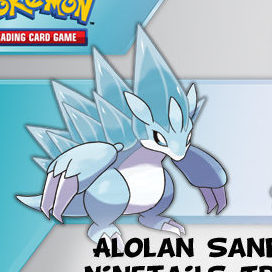

In [12]:
image

In [13]:
train_dataset.classes[label]

'Alolan Sandslash'

In [14]:
print(f'Число классов: {len(train_dataset.classes)}')

Число классов: 150


В следующей ячейке описаны обучающие (с аугментациями) и тестовые трансформы (без аугментаций) для картинок

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [6]:
train_dataset = PokemonDataset(root='PokemonData', train=True, load_to_ram=True, transform=test_transform)
test_dataset = PokemonDataset(root='PokemonData', train=False, load_to_ram=True, transform=test_transform)

100%|██████████| 150/150 [00:11<00:00, 12.84it/s]


In [7]:
print(f'Число классов: {len(train_dataset.classes)}')

Число классов: 150


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Обучение модели из torchvision

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [11]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [12]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

num_epochs = 50
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [13]:
print(f'Количество параметров модели: {sum(param.numel() for param in model.parameters())}')

Количество параметров модели: 2416022


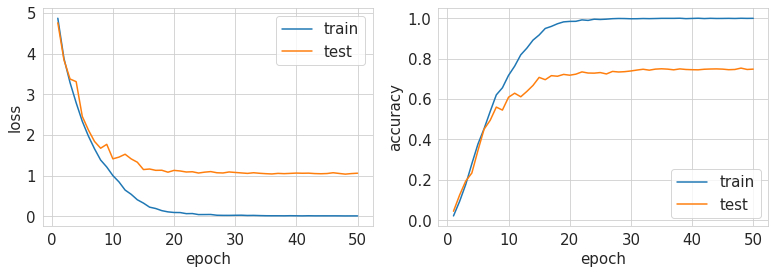

In [14]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

# Добавление аугментаций

In [16]:
train_dataset.transform = train_transform
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [17]:
model = mobilenet_v2(num_classes=len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

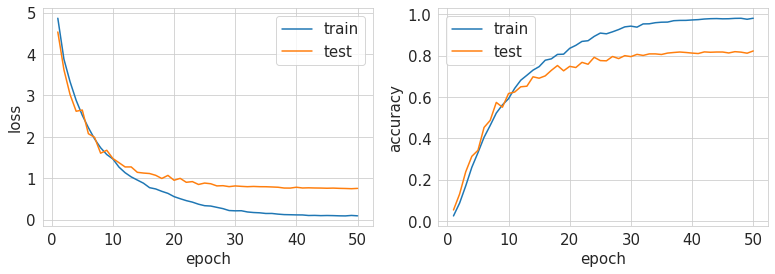

In [18]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs
)

# Fine-tuning предобученной модели

In [19]:
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [20]:
model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [21]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [24]:
# Заменяем исходную голову модели на голову с правильным числом классов
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 15)

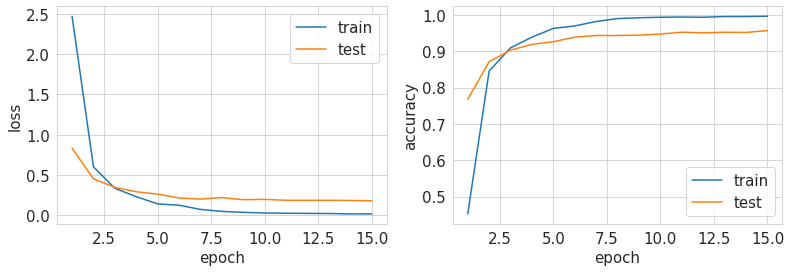

In [25]:
train_losses, test_losses, train_accuracies, test_accuracies = train(
    model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs=15
)